In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/BTech-project/

/content/drive/MyDrive/BTech-project


In [ ]:
# !unzip ./hindi-words-dataset.zip

In [ ]:
!ls

checkpoint	  CNN-GRU-CTC.ipynb	 hindi-words-dataset.zip
C_LSTM_best.hdf5  DevanagariOCRV1.ipynb  sig2


In [ ]:
# cat Readme.txt

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
def padding(image, target_height, target_width):
    # Apply padding to resize the image to the target dimensions while preserving aspect ratio
    # Example: Pad the image with zeros to achieve the target dimensions
    original_height, original_width = image.shape
    padding_top = (target_height - original_height) // 2
    padding_bottom = target_height - original_height - padding_top
    padding_left = (target_width - original_width) // 2
    padding_right = target_width - original_width - padding_left
    padded_image = cv2.copyMakeBorder(image, padding_top, padding_bottom, padding_left, padding_right, cv2.BORDER_CONSTANT, value=255)
    return padded_image

def gray_scale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def binarization(image):
    binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    binary_image = cv2.bitwise_not(binary_image)
    return binary_image

def image_blur(image):
    cleaned_image = cv2.GaussianBlur(image, (7, 7), 0)
    return cleaned_image

def remove_noise(image):
    # Apply morphological opening to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    # denoised_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    denoised_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return denoised_image

def image_histogram_equalize(image):
  # Apply image enhancement techniques (e.g., contrast adjustment, sharpening)
  enhanced_image = cv2.equalizeHist(image)
  return enhanced_image

def thin_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return image

'''
def rotate_and_deskew(image):
    # Invert binary image (assuming text is black on white background)
    binary_image = cv2.bitwise_not(image)

    # Find contours in the inverted binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour corresponds to the text region
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the minimum area bounding rectangle
        rect = cv2.minAreaRect(largest_contour)

        # Extract angle of rotation from the bounding rectangle
        angle = rect[-1]

        # Rotate the image to align text horizontally
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE if angle < -45 else cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Deskew the rotated image
        deskewed_image = deskew(rotated_image)

        return deskewed_image

def deskew(image):
    # Compute the skew angle using moments of the contour
    moments = cv2.moments(image)
    skew_angle = -moments['mu02'] / moments['mu11']

    # Deskew the image
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, skew_angle * 180 / np.pi, 1.0)
    deskewed_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return deskewed_image
'''
def rotation():
    return

In [ ]:
characters = ['-', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ',
              'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध',
              'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा',
              'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॐ', '॑', '॒', '॓', '॔', 'क़',
              'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७',
              '८', '९', '॰', 'ॱ', 'ॲ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ', ' ', '?','1','2','3','4','5','6','7','8','9','0', '.']

characters = sorted(characters)

In [ ]:
def preprocess_image(image, target_height = 32, target_width = 128):
    # Apply preprocessing steps to the image sequentially


    gray_scale_image = gray_scale(image)

    blur_image = image_blur(gray_scale_image)

    noise_removed = remove_noise(blur_image)

    binarized_image = binarization(noise_removed)

    noise_removed_2 = remove_noise(binarized_image)

    final_image = thin_font(noise_removed_2)

    return final_image

In [ ]:
# View sample preprocessed image
# image = cv2.imread(train_images[11])
# cv2_imshow(image)
# cv2_imshow(preprocess_image(image))

In [ ]:
def encode_to_labels(txt, char_list = characters):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [ ]:
encode_to_labels("क्या हाल है?")

[34, 88, 60, 73, 0, 70, 73, 63, 0, 70, 83, 13]

In [ ]:
# This value should the the length of max sentence in the vocabulary list
max_label_len = 50

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

class My_Generator(Sequence):

  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames, self.labels = image_filenames, labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

    images = []
    training_txt = []
    train_label_length = []
    train_input_length = []
    height = 32
    width = 128

    for im_path, text in zip(batch_paths, batch_texts):
      try:
        text = str(text).strip()
        path = os.path.join("./", im_path)
        if not os.path.exists(path):
          pass
        # img = preprocess_image(cv2.imread(path))
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ### actually returns h, w
        h, w = img.shape

        ### if height less than 32
        if h < height:
          add_zeros = np.ones((height-h, w)) * 255
          img = np.concatenate((img, add_zeros))
          h = height

        ## if width less than 128
        if w < width:
          add_zeros = np.ones((h, width-w)) * 255
          img = np.concatenate((img, add_zeros), axis=1)
          w = width

        ### if width is greater than 128 or height greater than 32

        if w >= width or h >= height:

          img = cv2.resize(img, (width, height))

          img = np.expand_dims(img , axis = 2)

          # Normalize each image
          img = img.astype(float) / 255.0

          images.append(img)
          # print(text, len(text), len(encode_to_labels(text)), "encoded:", encode_to_labels(text))
          training_txt.append(encode_to_labels(text))
          train_label_length.append(len(text))
          train_input_length.append(31)
      except:
        pass

    return [np.array(images),
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(characters)),
               np.array(train_input_length),
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
def my_data_generator(csv_file, image_dir):

    df = pd.read_csv(csv_file)
    df = df.iloc[:10]

    # Define lists to store images path and labels
    images = []
    labels = []

    # Iterate over rows in the CSV file
    for index, row in df.iterrows():
        # Get image path and label from the current row
        image_path = os.path.join(image_dir, row['image_name'])
        if not os.path.exists(image_path):
          print("path not found: ", image_path)
          return
        label = row['annotation']

        images.append(image_path)
        labels.append(label)

    return images, labels

In [ ]:
# csv_file = './sig2/sig.csv'  # Path to CSV file containing image paths and labels
image_dir = '../../MyDrive/hindi_project/hindi_words/'  # Path to directory containing images

train_csv = "../../MyDrive/hindi_project/hindi_words/train.csv"
# image_dir = './sig2'  # Path to directory containing images

val_csv = "../../MyDrive/hindi_project/hindi_words/val.csv"

test_csv = "../../MyDrive/hindi_project/hindi_words/test.csv"

batch_size = 16

train_images, train_labels = my_data_generator(train_csv, image_dir)
data_generator = My_Generator(train_images, train_labels, batch_size)

val_images, val_labels = my_data_generator(val_csv, image_dir)
val_generator = My_Generator(val_images, val_labels, batch_size)

test_images, test_labels = my_data_generator(test_csv, image_dir)
test_generator = My_Generator(test_images, test_labels, batch_size)

len_images = len(train_images)
len_labels = len(train_labels)

print("Training set: ", len(train_images), len(train_labels))
print("Validation set: ", len(val_images), len(val_labels))
print("Testing set: ", len(test_images), len(test_labels))

Training set:  10 10
Validation set:  10 10
Testing set:  10 10


In [ ]:
# cv2_imshow(data_generator[0][0][0][0] * 255)
print(data_generator[0][0][0].shape)
print(data_generator[0][1].shape)
print(data_generator[0][0][2].shape)
print(data_generator[0][0][3].shape)

(10, 32, 128, 1)
(10,)
(10,)
(10,)


In [ ]:
# Check sample from the generated batch
# if data_generator:
#   count = 0
#   for batch in data_generator:
#     if count == 1:
#       break
#     count += 1
#     for item in batch:
#       print("item: ", item)
#     # image, label = batch
#     # print(image[0].shape)
#     # print(label)

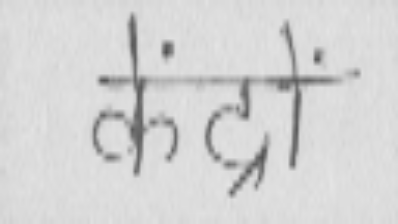

In [ ]:
# Function to display preprocessed samples using Matplotlib
def display_preprocessed_samples(dataset, num_samples=5):
    # Iterate over batches
    for batch in dataset:
        images, _ = batch
        # Display preprocessed samples from the batch
        for i in range(num_samples):
          image = images[0][i] * 255
          aspect_ratio = 16/9
          desired_height = 224
          desired_width = int(desired_height * aspect_ratio)
          image = cv2.resize(image, (desired_width, desired_height))
          # image = cv2.applyColorMap(image, cv2.COLORMAP)
          cv2_imshow(image)
            # plt.imshow(images[0][i], cmap='gray')
            # plt.axis('off')
            # plt.show()
        break  # Display samples from the first batch only

# Print preprocessed samples
display_preprocessed_samples(data_generator, num_samples=1)

In [ ]:
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# input with shape of height = 256 and width = 384
batch_size = 16
image_height = 32
image_width = 128
inputs = Input(shape=(image_height, image_width, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(characters) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func,
                  output_shape=(1,),
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

file_path = "C_LSTM_best.hdf5"

model.compile(metrics=['accuracy'], loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'Adam')

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(filepath=file_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')

callbacks_list = [early_stopping, reduce_lr, checkpoint]

In [ ]:
%%time
epochs = 1000

# Hindi = model.fit(data_generator,
#                     epochs = epochs,
#                     verbose = 1,
#                     callbacks = callbacks_list,
#                     shuffle=True)
# with tf.device("GPU:0"):
Hindi = model.fit(data_generator,
                    epochs = epochs,
                    steps_per_epoch = len(train_images) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_images) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

In [ ]:
plt.plot(Hindi.history['loss'])
plt.plot(Hindi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# Loading the weights of pre-trained model.
act_model.load_weights('C_LSTM_best.hdf5')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    print(prediction.shape)
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])
    ## get the final text
    for x in out:

        print("predicted text = ", end = '')

        for p in x:
            if int(p) != -1:
                print(characters[int(p)], end = '')

        print('\n')

In [ ]:
height = 32
width = 128

def process_image(path):
  img = preprocess_image(cv2.imread(path))

  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < height:
    add_zeros = np.ones((height-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = height

  ## if width less than 128
  if w < width:
    add_zeros = np.ones((h, width-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = width

  ### if width is greater than 128 or height greater than 32

  if w >= width or h >= height:
    img = cv2.resize(img, (width, height))

    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img.astype(float) / 255.0

    return img

In [ ]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(test_images))
    im = cv2.imread(test_images[index])
    display(im)

    # print("\n")

    test_img = process_image(test_images[index])
    predict_output(test_img)